In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, optimize
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.integrate import odeint
from lmfit import minimize, Parameters, fit_report
from matplotlib import ticker
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import random

%matplotlib inline

# Multi-Omics Data Analysis

In [2]:
#Change directory to file location

os.chdir('C:\\Users\\euler\\Documents\\Project\\Flux-Sensing')

In [3]:
gerosa = pd.read_excel('FS_data.xlsx',sheet_name='Gerosa',index_col = 'metab')
kochanowski = pd.read_excel('FS_data.xlsx',sheet_name='Kochanowski',index_col = 'metab')
bennett = pd.read_excel('FS_data.xlsx',sheet_name='Bennett', index_col = 'metab')
fluxes = pd.read_excel('FS_data.xlsx',sheet_name = 'Fluxes',index_col = 'flux')
thermo= pd.read_excel('FS_data.xlsx',sheet_name='Thermo',index_col='Metabolite')
mets = set(thermo.index)

In [4]:
metabs = set(gerosa.index).union(set(kochanowski.index))

In [5]:
data = pd.DataFrame(index = metabs)
data.drop('Citrate/Isocitrate',inplace=True)
for key in kochanowski.keys():
    data[key] = 0

In [6]:
#Collates 3 metabolomic and fluxomic data sets into one dataframe

for carbon_source in kochanowski.keys():
    if carbon_source.split('_')[1] == 'mean':
        if carbon_source in gerosa.keys():
            if carbon_source in bennett.keys():

                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = (3*gerosa[carbon_source].loc[metab] + 3*bennett[carbon_source][metab] + 4*kochanowski[carbon_source][metab])/10
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = (gerosa[carbon_source].loc[metab] + bennett[carbon_source][metab])/2
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
            else:
        
                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = (3*gerosa[carbon_source].loc[metab] + 4*kochanowski[carbon_source][metab])/7
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = gerosa[carbon_source].loc[metab]
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
        
        if carbon_source not in gerosa.keys():
            data[carbon_source] = kochanowski[carbon_source]
            
    if carbon_source.split('_')[1] == 'std':
        if carbon_source in gerosa.keys():
            if carbon_source in bennett.keys():

                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = np.sqrt((gerosa[carbon_source].loc[metab]**2 + bennett[carbon_source][metab]**2 + kochanowski[carbon_source][metab]**2)/3)
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = np.sqrt((gerosa[carbon_source].loc[metab]**2 + bennett[carbon_source][metab]**2)/2)
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
            else:
        
                for metab in data.index:
                    if metab in kochanowski.index and metab in gerosa.index:
                        data[carbon_source].loc[metab] = np.sqrt((2*gerosa[carbon_source].loc[metab]**2 + 3*kochanowski[carbon_source][metab]**2)/3)
                    elif metab not in kochanowski.index:
                        data[carbon_source].loc[metab] = gerosa[carbon_source].loc[metab]
                    else:
                        data[carbon_source].loc[metab] = kochanowski[carbon_source].loc[metab]
        
        if carbon_source not in gerosa.keys():
            data[carbon_source] = kochanowski[carbon_source]

C:\Users\euler\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
data.to_csv('metabolomics.csv',index=True)

In [7]:
means = data.loc[:,[x for x in data.keys() if x.split('_')[1] == 'mean']]

In [8]:
#Removes glutamate and malic enzyme flux from the dataframe (see Materials and Methods)

means = data.loc[:,[x for x in data.keys() if x.split('_')[1] == 'mean']]
means.drop('Glutamate',inplace=True)
mean_fluxes = fluxes.loc[:,[x for x in fluxes.keys() if x.split('_')[1] == 'mean']]
mean_fluxes.drop(index='ME',inplace=True)

Text(0.5, 0.05, 'Metabolite Concentration')

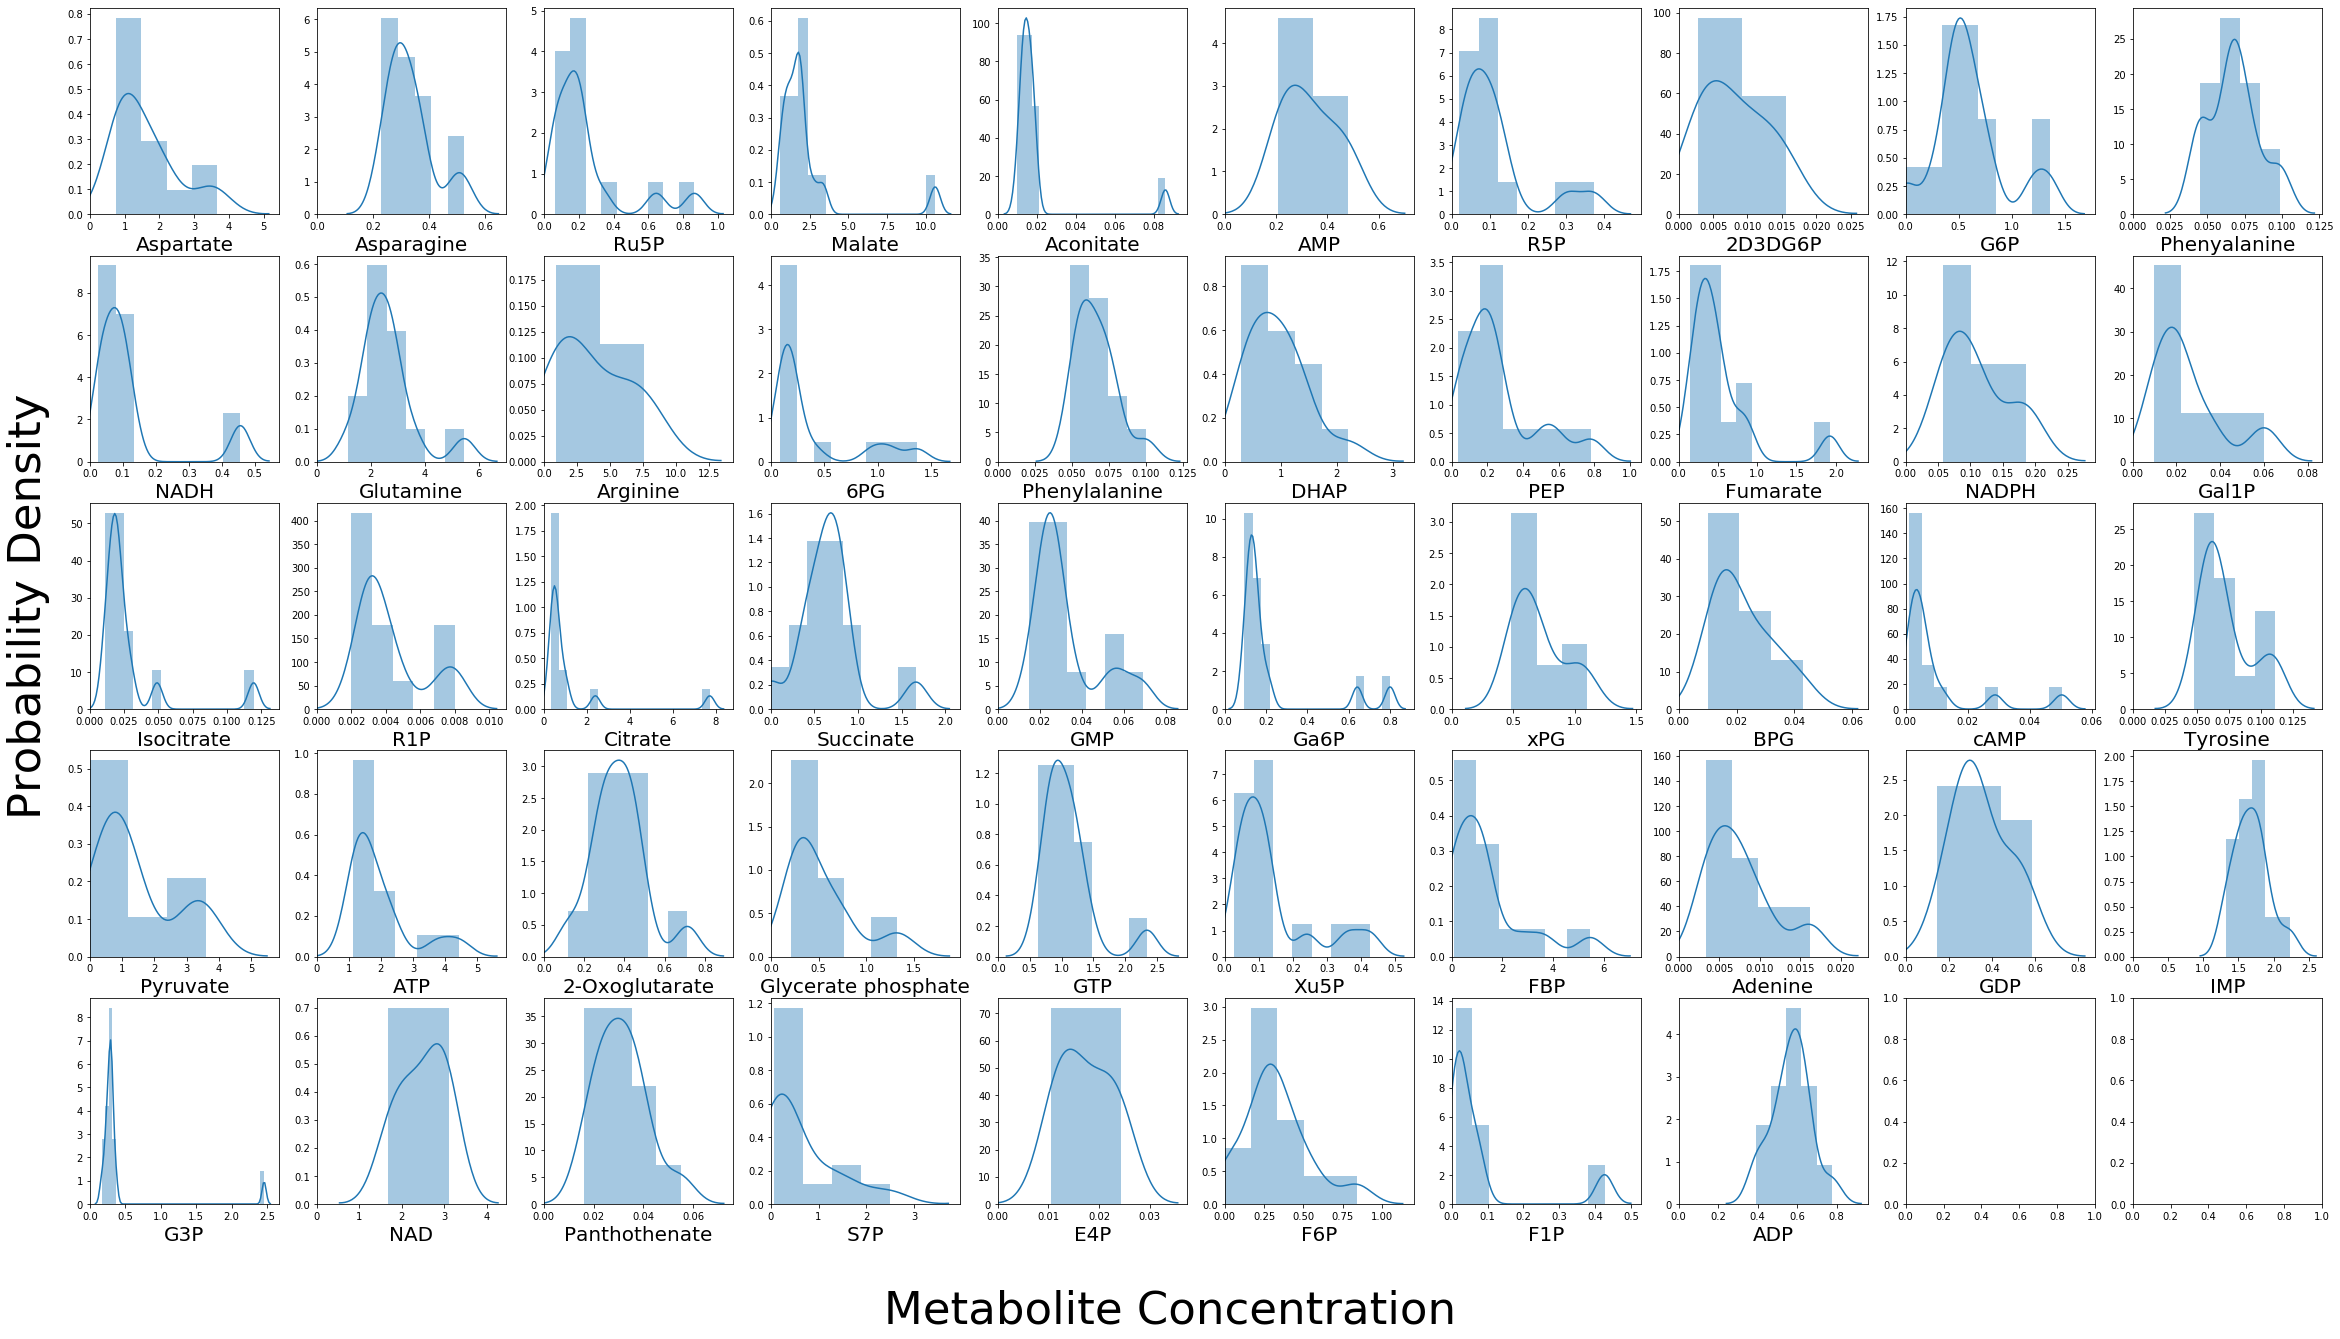

In [9]:
fig,ax = plt.subplots(5,10,figsize=(40,22))
ax = ax.flatten()

for i in range(0,len(means.index)-1):
    if i == 20:
        ax[i].set_ylabel('Probability Density',fontsize=45, labelpad=20)
        
    b = sns.distplot(means.loc[means.index[i],:],ax=ax[i])
    
    if means.index[i] == '2-dehydro-3-deoxy-D-gluconate 6-phosphate':
        b.set_xlabel('2D3DG6P',fontsize=20)
    else:
        b.set_xlabel(means.index[i],fontsize=20)
    ax[i].set_xlim(0,)
fig.text(0.5, 0.05, 'Metabolite Concentration', ha='center',fontsize=45)

#plt.savefig('distributions.pdf',bbox_inches='tight')
#plt.savefig('distributions.png',bbox_inches='tight')

In [10]:
#Creates a dataframe of the coefficients of variation for each metabolite concentration

CV = pd.DataFrame(index = data.index)
temp = []

for met in CV.index:
    temp.append(np.std(data.loc[met])/np.mean(data.loc[met]))
    
CV['CV'] = temp

In [11]:
stats.skew(CV['CV'])

1.2561903382667148

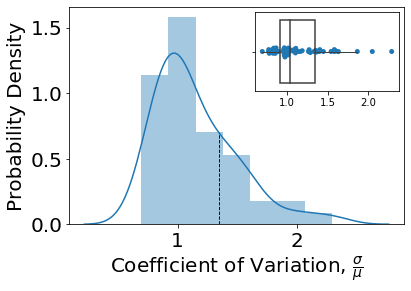

In [12]:
fig, ax = plt.subplots(1,1)

ax = sns.distplot(CV,kde=True)
ax.set_xlabel(r'Coefficient of Variation, $\frac{\sigma}{\mu}$',fontsize=20)
ax.set_ylabel('Probability Density',fontsize=20)
#ax.plot([IQ3, IQ3], [0.6,0.6], color='k', linestyle='-', linewidth=1)

axins = inset_axes(ax, width=2, height=1.1)
sns.boxplot(CV,showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':1},ax=axins)
sns.swarmplot(x='CV',data=CV,ax=axins,zorder=0)
axins.set(xlabel=None)

Q3 = np.quantile(CV['CV'],0.75)
ax.axvline(Q3,color='k',ymax=0.42,linestyle='--',linewidth=0.9)
ax.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('CVdist1.pdf',bbox_inches='tight')
#plt.savefig('CVdist1.png',bbox_inches='tight')

In [13]:
#One-sided T-test for differences of means of constraining Gibbs' free energy between CV quartile ranges 
p1 = stats.ttest_ind(thermo[thermo['quartile_range']=='Q2-Q3'].G0_mean,thermo[thermo['quartile_range']=='Q3-Max'].G0_mean,equal_var='False').pvalue/2
print(p1)

0.013531197275293253


In [14]:
p2 = stats.ttest_ind(thermo[thermo['quartile_range']=='Q1-Q2'].G0_mean,thermo[thermo['quartile_range']=='Q2-Q3'].G0_mean,equal_var='False').pvalue/2
print(p2)

0.4164873997320019


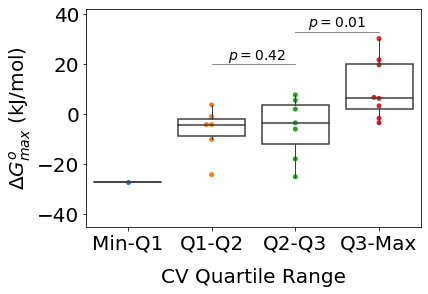

In [15]:
fig,ax = plt.subplots(1,1)

ax = sns.swarmplot(x = 'quartile_range',y='G0_mean',data=thermo, order=['Min-Q1','Q1-Q2','Q2-Q3','Q3-Max'], zorder=0)

sns.boxplot(x = 'quartile_range',y='G0_mean',data=thermo, 
                 showcaps=False,boxprops={'facecolor':'None'},
                 showfliers=False,whiskerprops={'linewidth':1}, ax=ax,
                order=['Min-Q1','Q1-Q2','Q2-Q3','Q3-Max'])
ax.set_xlabel('CV Quartile Range',fontsize=20, labelpad=15)
ax.set_ylabel(r'$\Delta G^o_{max}$ (kJ/mol)',fontsize=20,)
ax.set_ylim(-45,42)
ax.plot([2, 3], [33, 33], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(2.15,35,r'$p=$'+str(round(p1,2)),fontsize=14)
ax.plot([1, 2], [20, 20], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(1.2,22,r'$p=$'+str(round(p2,2)),fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('CV-Keq.pdf',bbox_inches='tight')
#plt.savefig('CV-Keq.png',bbox_inches='tight')

In [16]:
#Creates matrix of pearson r-values for correlations of each metabolite concentration against each measured flux

flux_corr = pd.DataFrame(index = mean_fluxes.index, columns = means.index)
corr_strength = pd.DataFrame(index = mean_fluxes.index, columns = means.index)

for i in mean_fluxes.index:
    for j in means.index:
        if means.loc[j,mean_fluxes.keys()].isnull().values.any():
            continue
        else:
            flux_corr.loc[i,j] = scipy.stats.pearsonr(mean_fluxes.loc[i,:], means.loc[j,mean_fluxes.keys()])[0]
            corr_strength.loc[i,j] = scipy.stats.linregress(mean_fluxes.loc[i,:], means.loc[j,mean_fluxes.keys()])[0]
            
flux_corr.drop(index = [x for x in flux_corr.index if 'Export' in x], columns = 'Gal1P',inplace=True)
flux_corr = flux_corr.astype('double')
corr_strength.drop(index = [x for x in corr_strength.index if 'Export' in x], columns = 'Gal1P',inplace=True)
corr_strength = corr_strength.astype('double')

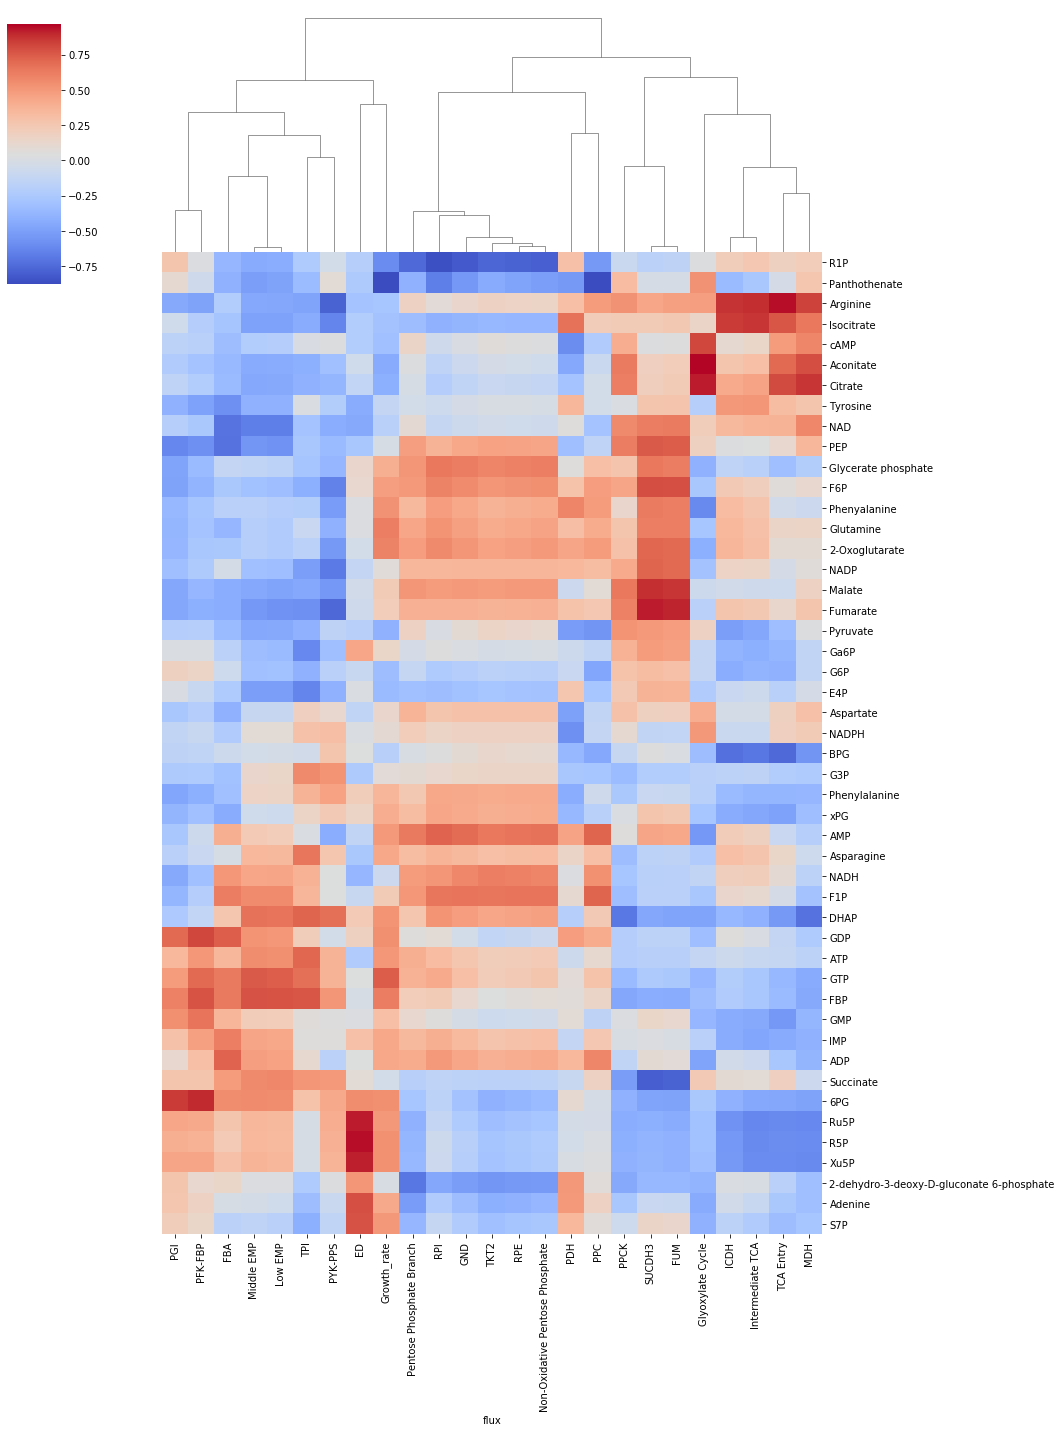

In [17]:
cm = sns.clustermap(flux_corr.T, cmap = 'coolwarm',figsize=(15,20))
cm.ax_row_dendrogram.set_visible(False)
#plt.savefig('clustergram.pdf',bbox_inches='tight')
#plt.savefig('clustergram.png',bbox_inches='tight')

In [18]:
#Saves correlation matrix to file

#flux_corr.to_csv('flux_corr.csv')

In [19]:
#Read in kinetic parameter data

BarrEven_kcat = pd.read_excel('kcat.xls',sheet_name='1. KineticTable',index_col='Organism ID')
Davidi_kcat = pd.read_excel('noor kcat.xlsx',sheet_name='kmax 1s')

BarrEven_kcat = BarrEven_kcat.loc[6] #Limit to E coli
Ks = BarrEven_kcat.loc[BarrEven_kcat['Reaction direction (KEGG)']==1]['KM']
k_f = BarrEven_kcat.loc[BarrEven_kcat['Reaction direction (KEGG)']==1]['kcat']

#Remove empty entries
Ks.dropna(inplace=True)
k_f.dropna(inplace=True)

Kp = BarrEven_kcat.loc[BarrEven_kcat['Reaction direction (KEGG)']==-1]['KM']
k_r = BarrEven_kcat.loc[BarrEven_kcat['Reaction direction (KEGG)']==-1]['kcat']
Kp.dropna(inplace=True)
k_r.dropna(inplace=True)

#Create distributions of parameter ratios

Kratio = [] 

for x in Kp:
    for y in Ks:
        Kratio.append(y/x)
        
kratio = []

for x in k_f:
    for y in k_f:
        if x == y:
            continue
        else:
            kratio.append(y/x)

for x in k_r:
    for y in k_r:
        if x == y:
            continue
        else:
            kratio.append(y/x)
            
#Sample constructed distributions to generate a distribution of grouped parameter values

prod_dist = []

for i in range(0,10000):
    prod_dist.append(random.choice(Kp.values)/random.choice(Ks.values)*random.choice(k_r.values)/random.choice(k_f.values))

C:\Users\euler\anaconda3\lib\site-packages\pandas\core\series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


ValueError: x and y must have same first dimension, but have shapes (1,) and (39,)

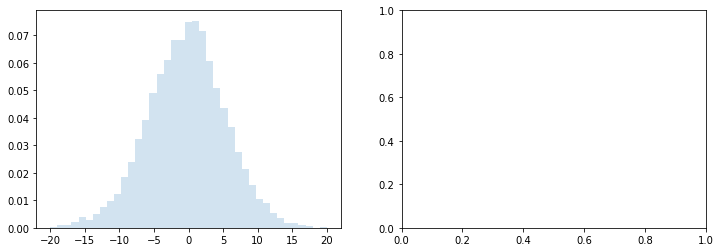

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax.flatten()

hist = ax[0].hist(np.log(prod_dist),cumulative=False,alpha=0.2,density=True,bins=np.linspace(-20,20,40))
#x = [(hist[1][i]+hist[1][i+1])/2 for i in range(0,len(hist[1])-1)]
ax[0].plot(x,hist[0],linewidth=0.75,color='k')
ax[0].axvline(np.quantile(np.log(prod_dist),0.5),ymax=0.95,linestyle='--',color='C00000',linewidth=0.75)
ax[0].axvline(np.quantile(np.log(prod_dist),0.9),ymax=0.4,linestyle='--',color='k',linewidth=0.75)
ax[0].text(-2.5,0.005, 'Median',color='C00000',fontsize=12,rotation=90)
ax[0].text(4.5,0.005, '90th Percentile',color='k',fontsize=12,rotation=90)
ax[0].set_ylabel('Probability Density',fontsize=20)

hist = ax[1].hist(np.log(prod_dist),cumulative=True,alpha=0.2,density=True,bins=np.linspace(-20,20,1000))
ax[1].plot(hist[1][1:],hist[0],linewidth=0.75,color='k')
ax[1].axvline(np.quantile(np.log(prod_dist),0.5),ymax=0.5,linestyle='--',color='C00000',linewidth=0.75)
ax[1].axvline(np.quantile(np.log(prod_dist),0.9),ymax=0.9,linestyle='--',color='k',linewidth=0.75)
ax[1].text(-2,0.1, 'Median',color='C00000',fontsize=12,rotation=90)
ax[1].text(5,0.1, '90th Percentile',color='k',fontsize=12,rotation=90)

ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_ylim(0,1)
ax[1].set_xlim(-20,20)
fig.text(0.5, -0.1, r"$\ln{\frac{K_p}{K_s}\frac{1}{k'K_{eq}}}$", ha='center',fontsize=25)
plt.tight_layout

plt.savefig('a_distribution.pdf',bbox_inches='tight')
plt.savefig('a_distribution.png',bbox_inches='tight')

In [21]:
#Calculate A_min for a range of Keq values and the relevant quantiles from the constructed parameter group distribution

def Amin(f,Keq):
    return np.log(1+f*1/Keq)

f =[np.quantile(prod_dist,0.1),np.median(prod_dist),np.quantile(prod_dist,0.9)]

Keq = np.logspace(-6,3,100)

A_min = Amin(f[0],Keq)
A_med = Amin(f[1],Keq)
A_max = Amin(f[2],Keq)

(-15, 26)

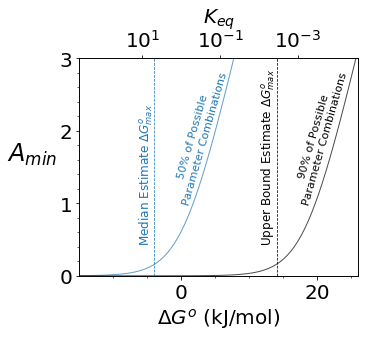

In [22]:
# Necessary functions

def tick_function(x):
    return ["%2.f" % i for i in x]

def func(x):
    funcx=-(298*8.314/1000)*np.log(x)
    return funcx
def invfunc(x):
    invfuncx=np.exp(-x*1000/(298*8.314))
    return invfuncx

# Set up the plot
fig,ax1 = plt.subplots(1,1,figsize=(5,4))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# Set up the second axis
ax2 = ax1.twiny()

# The tick positions can be at arbitrary positions
zticks=invfunc(Keq)
ax2.set_xticks(zticks)
ax2.set_xticklabels(tick_function(zticks))
ax2.set_xlim(invfunc(-15),invfunc(26))
ax2.set_xscale('log')

ax1.set_ylabel(r'$A_{min}$',fontsize=24,rotation=0,labelpad=27)
ax1.set_xlabel(r'$\Delta G^o$ (kJ/mol)',fontsize=20)
ax2.set_xlabel(r'$K_{eq}$',fontsize=20,labelpad=7)

_=ax1.plot(func(Keq),A_med,'-',alpha=0.7,linewidth=1)
_=ax1.plot(func(Keq),A_min,'k-',alpha=0.7,linewidth=1)

ax1.text(-1.7,1,'       50% of Possible \nParameter Combinations',fontsize=11,rotation=74,color='C00000')
ax1.text(16,1,'       90% of Possible \nParameter Combinations',fontsize=11,rotation=74)

ax1.text(-6.5,0.5,r'Median Estimate $\Delta G^o_{max}$',rotation=90,fontsize=12, color='C00000')
ax1.text(11.5,0.5,r'Upper Bound Estimate $\Delta G^o_{max}$',rotation=90,fontsize=12)

ax1.axvline(-4,linewidth=0.75,linestyle='--',color='C00000')
ax1.axvline(14,linewidth=0.75,linestyle='--',color='k')

ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax1.set_ylim(0,3)
ax1.set_xlim(-15,26)

#plt.savefig('actual_k_low.png',bbox_inches='tight')
#plt.savefig('actual_k_low.pdf',bbox_inches = 'tight')

In [23]:
#Calculate rolling median and 95% confidence interval based on thermodynamic constraints for each metabolite in the reduced
#data set (see Materials and Methods)

test = thermo.sort_values('G0_mean')
mean = test.rolling(window=4,min_periods=1,center=True).quantile(0.5)
low = test.rolling(window=4,min_periods=1,center=True).quantile(0.05)
high = test.rolling(window=4,min_periods=1,center=True).quantile(0.95)

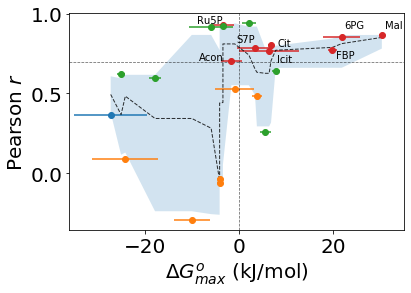

In [24]:
fig,ax = plt.subplots(1,1)

for met in mets:
    
    if thermo.loc[met].quartile_range == 'Min-Q1':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].pearson_r,xerr=thermo.loc[met].G0_std,color='C00000',fmt='o')
    if thermo.loc[met].quartile_range == 'Q1-Q2':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].pearson_r,xerr=thermo.loc[met].G0_std,color='C00001',fmt='o')
    if thermo.loc[met].quartile_range == 'Q2-Q3':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].pearson_r,xerr=thermo.loc[met].G0_std,color='C00002',fmt='o')
    if thermo.loc[met].quartile_range == 'Q3-Max':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].pearson_r,xerr=thermo.loc[met].G0_std,color='C00003',fmt='o')

ax.set_xlabel(r'$\Delta G^o_{max}$ (kJ/mol)',fontsize=20)
ax.set_ylabel(r'Pearson $r$',fontsize=20)
ax.set_xlim(-36,35)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.axvline(-0,linestyle='--',linewidth=0.75,alpha=0.6,color='k')
ax.axhline(0.7,linestyle='--',linewidth=0.75,alpha=0.6,color='k')

ax.text(21.8+0.6,0.91,'6PG',fontsize=10)
ax.text(30.3+0.6,0.91,'Mal',fontsize=10)
ax.text(19.8+0.8,0.72,'FBP',fontsize=10)
ax.text(8.1,0.8,'Cit',fontsize=10)
ax.text(8.1,0.7,'Icit',fontsize=10)
ax.text(-0.5,0.82,'S7P',fontsize=10)
ax.text(-8.5,0.71,'Acon',fontsize=10)
ax.text(-9,0.94,'Ru5P',fontsize=10)

ax.plot(thermo.sort_values('G0_mean')['G0_mean'],mean['pearson_r'],linestyle='--',linewidth=1,color='k',alpha=0.8)
ax.fill_between(thermo.sort_values('G0_mean')['G0_mean'],low['pearson_r'],high['pearson_r'],alpha=0.2)

#plt.savefig('r-Keq.pdf',bbox_inches='tight')
#plt.savefig('r-Keq.png',bbox_inches='tight')

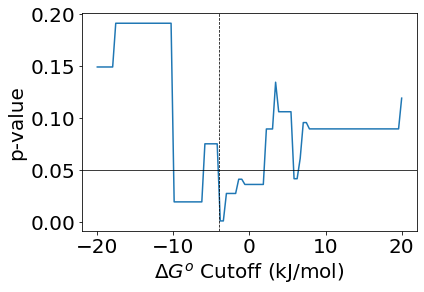

In [25]:
#Tests various Gibbs' free energy cutoffs based on p-values in a T-test. Each potential cutoff is used to split the data set
#then the mean Pearson r-values on either side of this constraint are compared in a T-test with the null hypothesis that there
#is no difference between the means.

G = np.linspace(-20,20,100)
p_vals = []
for g in G:
    p_vals.append(stats.ttest_ind(thermo[thermo['G0_mean']>=g].pearson_r,
                                  thermo[thermo['G0_mean']<g].pearson_r,equal_var='False').pvalue/2)
    
fig,ax = plt.subplots(1,1)
    
ax.plot(G,p_vals)
ax.axhline(0.05,linewidth=0.75, linestyle='-', color='k')

ax.set_xlabel(r'$\Delta G^o$ Cutoff (kJ/mol)',fontsize=20)
ax.set_ylabel('p-value',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.axvline(-4,linewidth=0.75,linestyle='--',color='k')

#plt.savefig('G cutoff.pdf',bbox_inches='tight')
#plt.savefig('G cutoff.png',bbox_inches='tight')

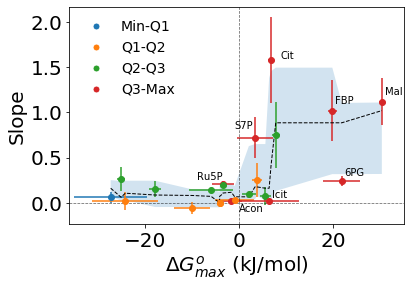

In [26]:
#This cell and the one that follows are the same as above, but using the slope estimated in the correlation matrix instead of 
#the Pearson r-value

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Min-Q1',
                          markerfacecolor='C00000', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Q1-Q2',
                          markerfacecolor='C00001', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Q2-Q3',
                          markerfacecolor='C00002', markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='Q3-Max',
                          markerfacecolor='C00003', markersize=7)]

fig,ax = plt.subplots(1,1)

for met in mets:
    
    if thermo.loc[met].quartile_range == 'Min-Q1':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].slope,xerr=thermo.loc[met].G0_std,
                    yerr=thermo.loc[met].slope_std,
                    color='C00000',fmt='o')
    if thermo.loc[met].quartile_range == 'Q1-Q2':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].slope,xerr=thermo.loc[met].G0_std,
                    yerr=thermo.loc[met].slope_std,
                    color='C00001',fmt='o')
    if thermo.loc[met].quartile_range == 'Q2-Q3':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].slope,xerr=thermo.loc[met].G0_std,
                    yerr=thermo.loc[met].slope_std,
                    color='C00002',fmt='o')
    if thermo.loc[met].quartile_range == 'Q3-Max':
        ax.errorbar(x=thermo.loc[met].G0_mean, y=thermo.loc[met].slope,xerr=thermo.loc[met].G0_std,
                    yerr=thermo.loc[met].slope_std,
                    color='C00003',fmt='o')

ax.set_xlabel(r'$\Delta G^o_{max}$ (kJ/mol)',fontsize=20)
ax.set_ylabel('Slope',fontsize=20)
ax.set_xlim(-36,35)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.axvline(0,linestyle='--',linewidth=0.75,alpha=0.6,color='k')
ax.axhline(0,linestyle='--',linewidth=0.75,alpha=0.6,color='k')

ax.text(21.8+0.6,0.3,'6PG',fontsize=10)
ax.text(30.3+0.6,1.2,'Mal',fontsize=10)
ax.text(19.8+0.6,1.1,'FBP',fontsize=10)
ax.text(8.3+0.6,1.6,'Cit',fontsize=10)
ax.text(7,0.06,'Icit',fontsize=10)
ax.text(-1,0.82,'S7P',fontsize=10)
ax.text(-0.1,-0.1,'Acon',fontsize=10)
ax.text(-9,0.25,'Ru5P',fontsize=10)

ax.legend(frameon=False,handles=legend_elements,loc='upper left',fontsize=14)
ax.plot(thermo.sort_values('G0_mean')['G0_mean'],mean['slope'],linestyle='--',linewidth=1,color='k')
ax.fill_between(thermo.sort_values('G0_mean')['G0_mean'],low['slope'],high['slope'],alpha=0.2)

#plt.savefig('slope-Keq.pdf',bbox_inches='tight')
#plt.savefig('slope-Keq.png',bbox_inches='tight')

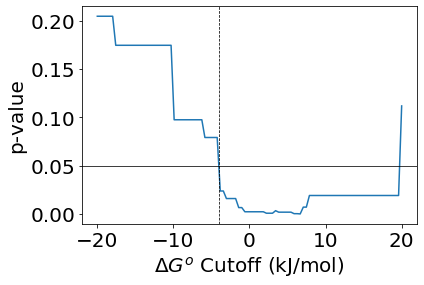

In [27]:
fig,ax = plt.subplots(1,1)

G = np.linspace(-20,20,100)
p_vals = []
for g in G:
    p_vals.append(stats.ttest_ind(thermo[thermo['G0_mean']>=g].slope,
                                  thermo[thermo['G0_mean']<g].slope,equal_var='False').pvalue/2)
    
ax.plot(G,p_vals)
ax.axhline(0.05,linewidth=0.75, linestyle='-', color='k')

ax.set_xlabel(r'$\Delta G^o$ Cutoff (kJ/mol)',fontsize=20)
ax.set_ylabel('p-value',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.axvline(-4,linewidth=0.75,linestyle='--',color='k')

#plt.savefig('G cutoff slope.pdf',bbox_inches='tight')
#plt.savefig('G cutoff slope.png',bbox_inches='tight')

-0.06265432716539407
-0.004420051214126187
0.02874395356884823
0.8828302165195842


Text(0.5, 0, 'Low EMP Flux (mM$\\cdot h^{-1}$)')

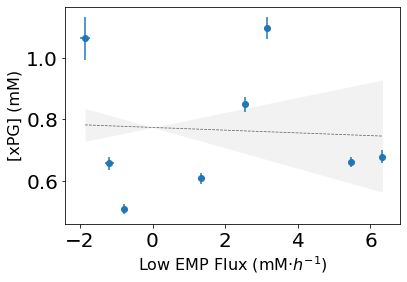

In [344]:
#Visualizes any correlation from the matrix. 

met = 'xPG' #Change this to the desired metabolite short code
flux = 'Low EMP' #and this to the desired flux

fig,ax = plt.subplots(1,1)

x = mean_fluxes.loc[flux]
xerr = fluxes.loc[flux,[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
x_model = np.linspace(x.sort_values(ascending=True)[0],x.sort_values(ascending=True)[-1])

y = means.loc[met,mean_fluxes.keys()]
yerr = data.loc[met,[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',label=met)
ax.set_ylabel('['+met+'] (mM)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=20)
    
slope, intercept, r_value, p_value, stderr = stats.linregress(x,y)
ax.plot(x_model,slope*x_model+intercept,linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)
ax.fill_between(x_model,(slope-stderr)*x_model+intercept,(slope+stderr)*x_model+intercept,alpha=0.05,color='k',linewidth=0)
#ax.text(0.5,1.2,'r = '+str(round(r_value,2)),fontsize=16)
print(r_value)
print(slope)
print(stderr)
print(p_value)
    
ax.set_xlabel(flux+ ' Flux (mM$\cdot h^{-1}$)', fontsize=16)

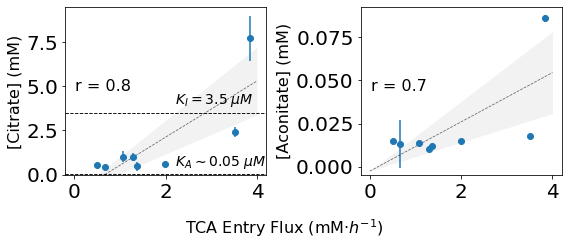

In [340]:
#Correlation analysis for citrate and aconitate with TCA cycle entry flux

lower = ['Citrate','Aconitate']

fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=False)
ax=ax.flatten()

x = mean_fluxes.loc['TCA Entry']
xerr = fluxes.loc['TCA Entry',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

for met in upper:

    y = means.loc[met,mean_fluxes.keys()]
    yerr = data.loc[met,[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
    ax[lower.index(met)].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',label=met)
    ax[lower.index(met)].set_ylabel('['+met+'] (mM)',fontsize=16)
    ax[lower.index(met)].tick_params(axis='both', which='major', labelsize=20)
    
    slope, intercept, r_value, p_value, stderr = stats.linregress(x,y)
    x_model = np.linspace(0,4,100)
    ax[lower.index(met)].plot(x_model,slope*x_model+intercept,linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)
    ax[lower.index(met)].fill_between(x_model,(slope-stderr)*x_model+intercept,(slope+stderr)*x_model+intercept,
                                      alpha=0.05,color='k',linewidth=0)
    ax[lower.index(met)].text(0.05,0.5,'r = '+str(round(r_value,2)),fontsize=16,transform = ax[lower.index(met)].transAxes)
    
ax[0].axhline(0.05,linestyle='--',color='k',linewidth=0.9)
ax[0].text(2.2,0.5,r'$K_A \sim 0.05 \; \mu M$',fontsize=14)

ax[0].axhline(3.5,linestyle='--',color='k',linewidth=0.9)
ax[0].text(2.2,4,r'$K_I = 3.5 \; \mu M$',fontsize=14)

ax[0].set_ylim(-0.05,)
ax[1].set_ylim(-0.005,)
    
fig.text(0.5, -0.1, 'TCA Entry Flux (mM$\cdot h^{-1}$)', ha='center',fontsize=16)

fig.tight_layout()

plt.savefig('TCA_entry.pdf',bbox_inches='tight')
plt.savefig('TCA_entry.png',bbox_inches='tight')

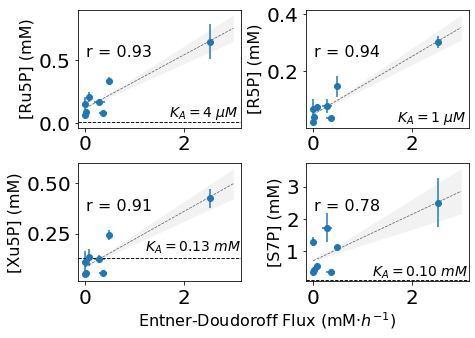

In [339]:
#Correlation analysis for pentose phosphate pathway intermediates and Entner-Doudoroff flux

PPP = ['Ru5P','R5P','Xu5P','S7P']

fig,ax = plt.subplots(2,2,figsize=(7,5))
ax = ax.flatten()

x = mean_fluxes.loc['ED']
xerr = fluxes.loc['ED',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

for met in PPP:

    y = means.loc[met,mean_fluxes.keys()]
    yerr = data.loc[met,[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
    ax[PPP.index(met)].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
    ax[PPP.index(met)].set_ylabel('['+met+'] (mM)',fontsize=16)
    ax[PPP.index(met)].tick_params(axis='both', which='major', labelsize=20)
    
    slope, intercept, r_value, p_value, stderr = stats.linregress(x,y)
    x_model = np.linspace(0,3,100)
    ax[PPP.index(met)].plot(x_model,slope*x_model+intercept,linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)
    ax[PPP.index(met)].fill_between(x_model,(slope-stderr)*x_model+intercept,(slope+stderr)*x_model+intercept,
                                    alpha=0.05,color='k',linewidth=0)
    ax[PPP.index(met)].text(0.05,0.6,'r = '+str(round(r_value,2)),fontsize=16,transform = ax[PPP.index(met)].transAxes)
    
    if met == 'Ru5P':
        ax[PPP.index(met)].axhline(0.004,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.7,0.05,r'$K_A = 4 \; \mu M$',fontsize=14)
        
    elif met == 'R5P':
        ax[PPP.index(met)].axhline(0.001,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.7,0.02,r'$K_A = 1 \; \mu M$',fontsize=14)
    elif met == 'Xu5P':
        ax[PPP.index(met)].axhline(0.13,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.2,0.16,r'$K_A = 0.13 \; mM$',fontsize=14)
    elif met == 'S7P':
        ax[PPP.index(met)].axhline(0.1,linestyle='--',color='k',linewidth=0.9)
        ax[PPP.index(met)].text(1.2,0.2,r'$K_A = 0.10 \; mM$',fontsize=14)

plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.3)
fig.text(0.5, 0.0005, 'Entner-Doudoroff Flux (mM$\cdot h^{-1}$)', ha='center',fontsize=16)
#fig.text(-0.04, 0.25, 'Concentrations (mM)', ha='center',fontsize=16, rotation=90)

plt.savefig('PPP-ED.pdf',bbox_inches='tight')
plt.savefig('PPP-ED.png',bbox_inches='tight')

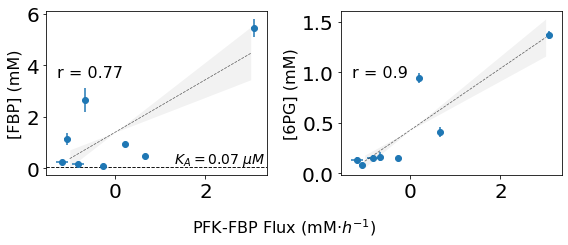

In [320]:
#Correlation analysis for metabolites with concentrations which correlate with upper glycolytic flux

upper = ['FBP','6PG']

fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=False)
ax=ax.flatten()

x = mean_fluxes.loc['PFK-FBP']
xerr = fluxes.loc['PFK-FBP',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

for met in upper:

    y = means.loc[met,mean_fluxes.keys()]
    yerr = data.loc[met,[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
    ax[upper.index(met)].errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',label=met)
    ax[upper.index(met)].set_ylabel('['+met+'] (mM)',fontsize=16)
    ax[upper.index(met)].tick_params(axis='both', which='major', labelsize=20)
    
    slope, intercept, r_value, p_value, stderr = stats.linregress(x,y)
    x_model = np.linspace(-1,3,100)
    ax[upper.index(met)].plot(x_model,slope*x_model+intercept,linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)
    ax[upper.index(met)].fill_between(x_model,(slope-stderr)*x_model+intercept,(slope+stderr)*x_model+intercept,
                                      alpha=0.05,color='k',linewidth=0)
    ax[upper.index(met)].text(0.05,0.6,'r = '+str(round(r_value,2)),fontsize=16,transform = ax[upper.index(met)].transAxes)
    
fig.text(0.5, -0.1, 'PFK-FBP Flux (mM$\cdot h^{-1}$)', ha='center',fontsize=16)

ax[0].axhline(0.07,linestyle='--',color='k',linewidth=0.9)
ax[0].text(1.3,0.21,r'$K_A = 0.07 \; \mu M$',fontsize=14)

fig.tight_layout()
plt.savefig('upper_glycolytic.pdf',bbox_inches='tight')
plt.savefig('upper_glycolytic.png',bbox_inches='tight')

In [36]:
#This and the following cells are for non-linear correlation between concentrations and fluxes. Citrate and TCA Entry are
#correlated first, followed by malate and fumarase

def residual(params, x, data, eps_data):
    V_m = params['V_m']
    alpha = params['alpha']
    beta = params['beta']

    model = x/(V_m-x)*alpha+beta

    return (data-model)**2

In [39]:
params = Parameters()
params.add('V_m', value=4.59, min=0)
params.add('alpha', value=1.17,min=0)
params.add('beta',value=0.01,min=0)

In [40]:
x = mean_fluxes.loc['TCA Entry']
y = means.loc['Citrate',mean_fluxes.keys()]
xerr = fluxes.loc['TCA Entry',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['Citrate',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

out = minimize(residual, params, args=(x.values, y.values, yerr.values))

In [41]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 8
    # variables        = 3
    chi-square         = 0.02500057
    reduced chi-square = 0.00500011
    Akaike info crit   = -40.1463862
    Bayesian info crit = -39.9080616
[[Variables]]
    V_m:    3.95343420 +/- 0.03842810 (0.97%) (init = 4.59)
    alpha:  0.20925941 +/- 0.06243991 (29.84%) (init = 1.17)
    beta:   0.62503273 +/- 0.06983293 (11.17%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(V_m, alpha)  =  0.921
    C(alpha, beta) = -0.546
    C(V_m, beta)   = -0.470


In [42]:
#R^2 value

1 - out.redchi / np.var(y, ddof=2)

0.999309633027489

In [43]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
V_m,3.95343420,0.03842810,(0.97%),4.59,0.00000000,inf,True
alpha,0.20925941,0.06243991,(29.84%),1.17,0.00000000,inf,True
beta,0.62503273,0.06983293,(11.17%),0.01,0.00000000,inf,True


In [44]:
def model(x,V_m,alpha,beta):
    return x/(V_m-x)*alpha+beta

(-0.1, 10)

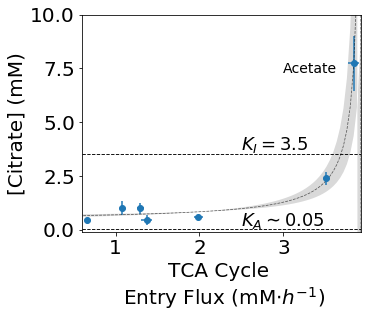

In [45]:
fig,ax = plt.subplots(figsize=(5,4))

x_model = np.linspace(0,4,100)
x = mean_fluxes.loc['TCA Entry']
y = means.loc['Citrate',mean_fluxes.keys()]
xerr = fluxes.loc['TCA Entry',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['Citrate',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

V = out.params['V_m'].value
V_upper = out.params['V_m'].value + out.params['V_m'].stderr
V_lower = out.params['V_m'].value - out.params['V_m'].stderr

a = out.params['alpha'].value
a_upper = out.params['alpha'].value + out.params['alpha'].stderr
a_lower = out.params['alpha'].value - out.params['alpha'].stderr

b = out.params['beta'].value
b_upper = out.params['beta'].value + out.params['beta'].stderr
b_lower = out.params['beta'].value - out.params['beta'].stderr

ax.axhline(0.05,linestyle='--',color='k',linewidth=0.9)
ax.axhline(3.5,linestyle='--',color='k',linewidth=0.9)
ax.fill_between(x_model,model(x_model,V_lower,a_upper,b_lower),
                model(x_model,V_upper,a_lower,b_upper),alpha=0.15,
                color='k',linewidth=0)
ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
ax.plot(x_model,model(x_model,V,a,b),linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)

ax.set_xlabel('TCA Cycle \n Entry Flux (mM$\cdot h^{-1}$)',fontsize=20)
ax.set_ylabel('[Citrate] (mM)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.text(3,7.3,'Acetate',fontsize=14)
ax.text(2.5,3.72,r'$K_I = 3.5$', fontsize=18)
ax.text(2.5,0.2,r'$K_A \sim 0.05$',fontsize=18)

plt.xlim(0.6,3.925)
plt.ylim(-0.1,10)

#plt.savefig('TCA-citrate.pdf',bbox_inches='tight')
#plt.savefig('TCA-citrate.png',bbox_inches='tight')

In [46]:
params = Parameters()
params.add('V_m', value=20, min=0)
params.add('alpha', value=1,min=0)
params.add('beta',value=1,min=0)

In [47]:
x = mean_fluxes.loc['FUM']
y = means.loc['Malate',mean_fluxes.keys()]
xerr = fluxes.loc['FUM',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]
yerr = data.loc['Malate',[x for x in fluxes.keys() if x.split('_')[1] == 'std']]

out = minimize(residual, params, args=(x.values, y.values, yerr.values))

In [48]:
print(fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 142
    # data points      = 8
    # variables        = 3
    chi-square         = 1.00121816
    reduced chi-square = 0.20024363
    Akaike info crit   = -10.6257930
    Bayesian info crit = -10.3874684
[[Variables]]
    V_m:    8.21735143 +/- 0.52114666 (6.34%) (init = 20)
    alpha:  0.90534541 +/- 0.54016442 (59.66%) (init = 1)
    beta:   1.30065360 +/- 0.20533891 (15.79%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(V_m, alpha)  =  0.866
    C(alpha, beta) = -0.706
    C(V_m, beta)   = -0.561


In [49]:
1 - out.redchi / np.var(y, ddof=2)

0.9831167581777073

In [50]:
out.params

name,value,standard error,relative error,initial value,min,max,vary
V_m,8.21735143,0.52114666,(6.34%),20,0.00000000,inf,True
alpha,0.90534541,0.54016442,(59.66%),1,0.00000000,inf,True
beta,1.30065360,0.20533891,(15.79%),1,0.00000000,inf,True


(0, 12.5)

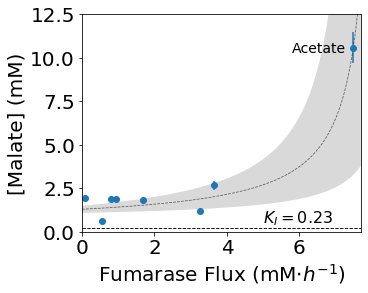

In [51]:
fig,ax = plt.subplots(figsize=(5,4))

x_model=np.linspace(0,8.2,100)

V = out.params['V_m'].value
V_upper = out.params['V_m'].value + out.params['V_m'].stderr
V_lower = out.params['V_m'].value - out.params['V_m'].stderr

a = out.params['alpha'].value
a_upper = out.params['alpha'].value + out.params['alpha'].stderr
a_lower = out.params['alpha'].value - out.params['alpha'].stderr

b = out.params['beta'].value
b_upper = out.params['beta'].value + out.params['beta'].stderr
b_lower = out.params['beta'].value - out.params['beta'].stderr

x_model = np.linspace(0,7.7,1000)

ax.axhline(0.23,linestyle='--',color='k',linewidth=0.9)
ax.fill_between(x_model,model(x_model,V_upper,a_lower,b_lower),
                model(x_model,V_lower,a_upper,b_upper),alpha=0.15,
                color='k',linewidth=0)
ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
ax.plot(x_model,model(x_model,V,a,b),linestyle = '--',linewidth = 0.75,color='k',alpha=0.6)

ax.set_xlabel(r'Fumarase Flux (mM$\cdot h^{-1}$)',fontsize=20)
ax.set_ylabel('[Malate] (mM)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.text(5,0.5,r'$K_I = 0.23$',fontsize=16)
ax.text(5.8,10.3,'Acetate',fontsize=14)

plt.xlim(0,7.7)
plt.ylim(0,12.5)
#plt.savefig('FUM-malate.pdf',bbox_inches='tight')
#plt.savefig('FUM-malate.png',bbox_inches='tight')

# Model

In [182]:
#Functions describing the relationship between upstream flux and concentration for the irreversible case

def irrev(x): #For the scaled steady-state concentration of S as a function of scaled flux u
    return x/(1-x)

def irrev_sens(x): #For the sensitivity of S to u
    return 1/(1-x)**2

In [183]:
#Functions describing the relationship between upstream flux and concentration for the reversible case, as above

def rev(x,Ks,Kp,k,Keq):
    return x/(1-x)*(1+(k*Keq)**(-1)*Kp/Ks+(k)**(-1)*x)

def rev_sens(x,Ks,Kp,k,Keq):
    return 1/(1-x)**2*(1+((2-x)*x/k+(Kp/Ks)/(k*Keq)))

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, -0.05, '$\\tilde{u}$')

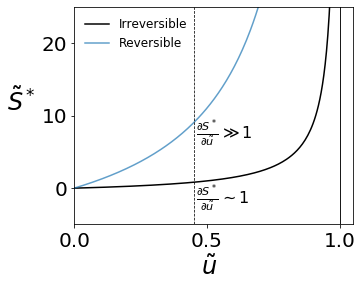

In [87]:
fig,ax = plt.subplots(1,1,figsize=(5,4))

x = np.linspace(0,1,200)
Ks = 0.1
Kp = 1
k = 10
Keq = 0.1

ax.plot(x,irrev(x), color = 'k', label = 'Irreversible')
ax.axvline(1,linestyle='-',color='k',linewidth=0.9)

ax.set_ylim(-5,25)
ax.set_xlim(0,1.05)
ax.set_ylabel(r'$\tilde{S}^*$',fontsize=24,rotation=0,labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.plot(x,rev(x,Ks,Kp,k,Keq), color = 'C00000',alpha=0.7,label='Reversible')

ax.axvline(0.45,linewidth=0.75, linestyle='--',color='k')
ax.text(0.46,7,r'$\frac{\partial S^*}{\partial \tilde{u}} \gg 1$',fontsize=16)
ax.text(0.46,-2,r'$\frac{\partial S^*}{\partial \tilde{u}} \sim 1$',fontsize=16)

ax.legend(frameon=False, loc='best', fontsize=12)

fig.text(0.5, -0.05,r'$\tilde{u}$',fontsize=24, ha='center')

#plt.savefig('compare.png',bbox_inches='tight')
#plt.savefig('compare.pdf',bbox_inches = 'tight')

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


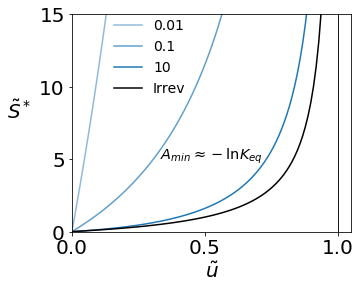

In [195]:
fig,ax = plt.subplots(figsize=(5,4))
x = np.linspace(0,1,100)
K_vals = [0.01,0.1,10]
k = 1
Kp = 1
Ks = 1
alpha = [0.5,0.7,1]

for K in K_vals:
    ax.plot(x,rev(x,Ks,Kp,k,K),color = 'C00000',alpha=alpha[K_vals.index(K)],label = str(K))
ax.plot(x,irrev(x),color='k',label='Irrev')
ax.set_ylim(0,15)
ax.set_xlim(0,1.05)
#ax.plot(x,irrev(x,V,Ks),color='k',label = 'Irreversible')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc=(0.13,0.6),frameon=False,facecolor='w',framealpha=1,fontsize=14)
#fig.text(0.5, -0.01, r'$\tilde{u}$',fontsize=24, ha='center',labelpad=20)
ax.set_ylabel(r'$\tilde{S}^*$',fontsize=20,rotation=0,labelpad=20)
ax.set_xlabel(r'$\tilde{u}$',fontsize=20,rotation=0)
ax.axvline(1,linestyle='-',color='k',linewidth=0.9)

ax.text(0.33,5,r'$A_{min}\approx-\ln{K_{eq}}$',fontsize=14.5)
#ax.text(0.4,5,r'$\frac{\partial S^*}{\partial \tilde{u}} \sim K_{eq}^{-1}$',fontsize=18)

plt.savefig('thermo.pdf',bbox_inches='tight')
plt.savefig('thermo.png',bbox_inches='tight')

In [90]:
x = np.linspace(0,3,200)
Ks = 1
Kp = 1
k_vals = [0.01,1,10,100,1000]
Keq = np.logspace(-6,6,100)

sensitivities = []

for k in k_vals:
    sensitivities.append(rev_sens(0,Ks,Kp,k,Keq))

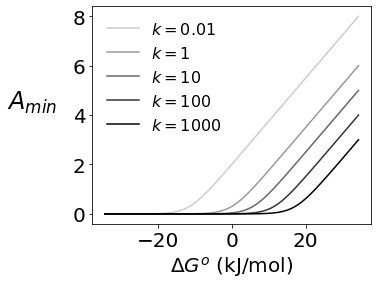

In [91]:
fig,ax = plt.subplots(1,1,figsize=(5,4))

G = -(298*8.314/1000)*np.log(Keq)
alphas = [0.2,0.4,0.6,0.8,1]

for i in range(0,len(k_vals)):
    ax.plot(G,np.log10(sensitivities[i]),label=r"$k=$"+str(k_vals[i]),color='k',alpha=alphas[i])

ax.ticklabel_format(axis='y', scilimits=(0,0))

ax.set_ylabel(r'$A_{min}$',fontsize=24,rotation=0,labelpad=40)
ax.set_xlabel(r'$\Delta G^o$ (kJ/mol)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(frameon=False,fontsize=16,loc='best')


#plt.savefig('rev_sens.png',bbox_inches='tight')
#plt.savefig('rev_sens.pdf',bbox_inches = 'tight')

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


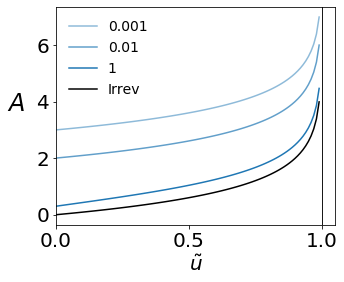

In [92]:
fig,ax = plt.subplots(figsize=(5,4))
x = np.linspace(0,1,100)
K_vals = [0.001,0.01,1]
k = 1
Kp = 1
Ks = 1
alpha = [0.5,0.7,1]

for K in K_vals:
    ax.plot(x,np.log(rev_sens(x,Ks,Kp,k,K)),color = 'C00000',alpha=alpha[K_vals.index(K)],label = str(K))
ax.plot(x,np.log(irrev_sens(x)),color='k',label='Irrev')

ax.set_xlim(0,1.05)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc='best',frameon=False,facecolor='w',framealpha=1,fontsize=14)

ax.set_ylabel(r'$A$',fontsize=24,rotation=0,labelpad=20)
ax.set_xlabel(r'$\tilde{u}$',fontsize=20,rotation=0)
ax.axvline(1,linestyle='-',color='k',linewidth=0.9)

#plt.savefig('sensitivity.pdf',bbox_inches='tight')
#plt.savefig('sensitivity.png',bbox_inches='tight')

In [93]:
#Dynamic function describing the linear feedforward motif with k[0] as input flux

def linear_feedforward(x,t,k):
    
    dsdt = k[0] - (1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)*k[2]
    dpdt = (1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)*k[2] - k[3]*x[1]/(k[4]+x[1])*(1+x[0]/(k[5]+x[0]))
    
    return [dsdt,dpdt]

def out_flux(x,k):
    return k[3]*x[1]/(k[4]+x[1])*(1+x[0]/(k[5]+x[0]))

In [110]:
#Calculates the steady-state substrate concentration in the feedforward activation system for various scenarios

x0 = [1,0]
influxes = np.linspace(0,1,800)

n = 1000
t = np.linspace(0,1000,n)

s_ss = []
s_ss_no = []
s_ss_k = []
out = []
out_no = []
out_k = []

for flux in influxes:
    k = [flux,0.01,1,1,0.1,0.1]
    y = odeint(linear_feedforward,x0,t,args=(k,))
    s_ss.append(y[-1][0])
    out.append(out_flux(y[-1],k))
    
    k = [flux,0.01,1,1,0.1,1000]
    y = odeint(linear_feedforward,x0,t,args=(k,))
    s_ss_no.append(y[-1][0])
    out_no.append(out_flux(y[-1],k))
    
    k = [flux,1000,1,1,0.1,0.1]
    y = odeint(linear_feedforward,x0,t,args=(k,))
    s_ss_k.append(y[-1][0])
    out_k.append(out_flux(y[-1],k))

(0, 1)

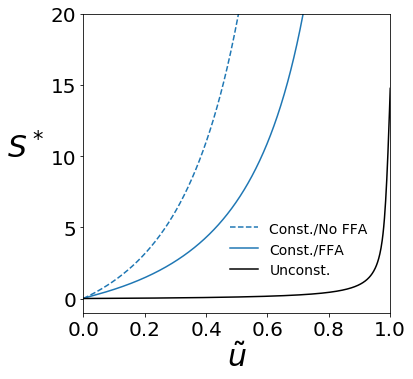

In [111]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

ax.plot(influxes,s_ss_no,linestyle='--',color='C00000',label='Const./No FFA')
ax.plot(influxes,s_ss,linestyle='-',color='C00000',label='Const./FFA')
ax.plot(influxes,s_ss_k,linestyle='-',color='k',label='Unconst.')

ax.set_xlabel(r'$\tilde{u}$',fontsize=30)
ax.set_ylabel(r'$S^*$',fontsize=30,rotation=0,labelpad=25)

ax.legend(frameon=False,fontsize=14,loc=(0.46,0.1))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylim(-1,20)
ax.set_xlim(0,1)

#plt.savefig('ss_FFA.pdf',bbox_inches='tight')
#plt.savefig('ss_FFA.png',bbox_inches='tight')

In [94]:
x0 = [0.001,0]
n = 10000
t = np.linspace(0,10000,n)
Ks = np.logspace(-3,2,1000)
tau = [] #Response time for the unregulated system
tau_reg = [] #Response time for the regulated system

for K in Ks:
    k = [1,K,1,1,0.1,0.1]
    y = odeint(linear_feedforward,x0,t,args=(k,))
    out = [out_flux(x,k) for x in y]
    tau_reg.append(t[out/max(out)>=0.632][0]) #The response time is the first time at or after which ~63% of full response 
                                              #is achieved
    
    k = [1,K,1,1,0.1,1000]
    y = odeint(linear_feedforward,x0,t,args=(k,))
    out = [out_flux(x,k) for x in y]
    tau.append(t[out/max(out)>=0.632][0])

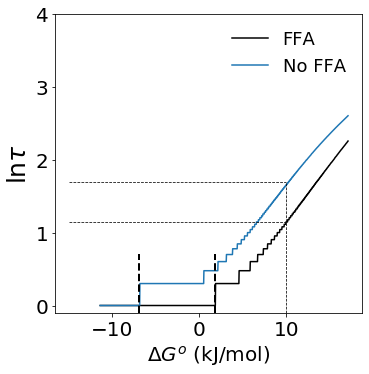

In [95]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

ax.plot(-(8.314*298/1000)*np.log(Ks),np.log10(tau_reg),linestyle='-',color='k',label='FFA')
ax.plot(-(8.314*298/1000)*np.log(Ks),np.log10(tau),linestyle='-',color='C00000',label='No FFA')

ax.set_xlabel(r'$\Delta G^o$ (kJ/mol)',fontsize=20,rotation=0)
ax.set_ylabel(r'$\ln{\tau}$',fontsize=25,rotation=90)

ax.plot([-7,-7],[-0.1,0.7],linestyle='--',color='k',linewidth=2)
ax.plot([1.75,1.75],[-0.1,0.7],linestyle='--',color='k',linewidth=2)

ax.plot([-15,10],[1.7,1.7],linestyle='--',color='k',linewidth=0.75)
ax.plot([-15,10],[1.15,1.15],linestyle='--',color='k',linewidth=0.75)
ax.plot([10,10],[-0.1,1.7],linestyle='--',color='k',linewidth=0.75)

ax.set_ylim(-0.1,4)
#ax.set_xlim(-12,32)

ax.legend(frameon=False, fontsize=18,loc='best')
ax.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('tau-G.pdf',bbox_inches='tight')
#plt.savefig('tau-G.png',bbox_inches='tight')

In [55]:
#Same as above dynamic function, but with a time delay

def linear_feedforward_delay(x,t,k):
    
    if t < 10:
        dsdt =  0 - (1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)*k[2]
        dpdt = (1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)*k[2] - k[3]*x[1]/(k[4]+x[1])*(1+x[0]/(k[5]+x[0]))
    
        return [dsdt,dpdt]
    
    else:
        dsdt = k[0] - (1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)*k[2]
        dpdt = (1-x[1]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)*k[2] - k[3]*x[1]/(k[4]+x[1])*(1+x[0]/(k[5]+x[0]))
    
        return [dsdt,dpdt]

def out_flux(x,k):
    return k[3]*x[1]/(k[4]+x[1])*(1+x[0]/(k[5]+x[0]))

In [224]:
x0 = [0.001,0]

t = np.linspace(0,1000,1000)

k = [1,0.01,1,1,0.1,0.1]
y_reg = odeint(linear_feedforward_delay,x0,t,args=(k,))
out_reg = [out_flux(x,k) for x in y_reg]

k = [1,0.01,1,1,0.1,1000]
y = odeint(linear_feedforward_delay,x0,t,args=(k,))
out = [out_flux(x,k) for x in y]

k = [1,1000,1,1,0.1,1000]
y_ = odeint(linear_feedforward_delay,x0,t,args=(k,))
out_ = [out_flux(x,k) for x in y_]

k = [1,1000,1,1,0.1,0.1]
y_both = odeint(linear_feedforward_delay,x0,t,args=(k,))
out_both = [out_flux(x,k) for x in y_both]

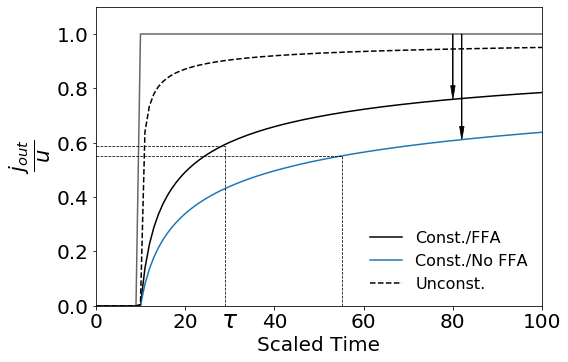

In [226]:
fig,ax = plt.subplots(figsize=(8,5.5))

ax.plot(t,np.divide(out_reg,1),linestyle='-',color='k',label='Const./FFA')
ax.plot(t,np.divide(out,1),linestyle='-',color='C00000',label='Const./No FFA')
ax.plot(t,np.divide(out_,1),linestyle='--',color='k',label='Unconst.')
ax.plot(t,x,color='k',alpha=0.6)

ax.set_xlabel('Scaled Time',fontsize=20,rotation=0)
ax.set_ylabel(r'$\frac{j_{out}}{u}$',fontsize=30,rotation=90)

tau = t[out/max(out) >= 0.632][0]
tau_reg = t[out_reg/max(out_reg) >= 0.632][0]
tau_ = t[out_/max(out_) >= 0.632][0]

ax.plot([0,tau],[0.632*max(out),0.632*max(out)],linestyle='--',linewidth=0.75,color='k')
ax.plot([tau,tau],[0,0.632*max(out)],linestyle='--',linewidth=0.75,color='k')

ax.plot([0,tau_reg],[0.632*max(out_reg),0.632*max(out_reg)],linestyle='--',linewidth=0.75,color='k')
ax.plot([tau_reg,tau_reg],[0,0.632*max(out_reg)],linestyle='--',linewidth=0.75,color='k')

ax.arrow(82,1,0,-0.39,linestyle='-',linewidth=0.75,color='k',length_includes_head=True,
          head_width=1, head_length=0.05)
ax.arrow(80,1,0,-0.24,linestyle='-',linewidth=0.75,color='k',length_includes_head=True,
          head_width=1, head_length=0.05)

ax.text(tau_reg-1,-0.08,r'$\tau$',fontsize=25)

ax.set_xlim(0,100)
ax.set_ylim(0,1.1)

ax.legend(frameon=False, fontsize=16,loc='best')
ax.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('response.pdf',bbox_inches='tight')
#plt.savefig('response.png',bbox_inches='tight')

In [106]:
#Dynamic functions describing the feedforward split motif

def split(x,t,k):
    
    dxdt = k[4] - (1-x[1]/x[0]/k[7])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1)
    dpdt = (1-x[1]/x[0]/k[7])*(x[0]/0.1)/(1+x[0]/0.1+x[1]/1) - k[0]*x[1]/(k[1]+x[1])*k[5]/(k[5]+x[0]) - k[2]*x[1]/(k[3]+x[1])
    dydt = k[0]*x[1]/(k[1]+x[1])*k[5]/(k[5]+x[0]) - k[0]*x[2]/(k[1]+x[2])
    dzdt = k[2]*x[1]/(k[3]+x[1]) - k[2]*x[3]/(k[1]+x[3])
    
    return [dxdt,dpdt,dydt,dzdt]

def j(x,k):
    j_y = k[0]*x[2]/(k[1]+x[2])
    j_z = k[2]*x[3]/(k[1]+x[3])
    
    return [j_y,j_z]

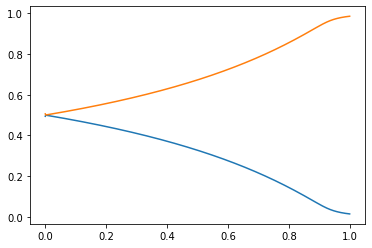

In [107]:
#Provides a step input flux at time zero, then calculates the fraction of this flux going into either branch of the split
x0 = [0.1,0,0,0]
influxes = np.linspace(0,1,800)

n = 100
t = np.linspace(0,100,n)

frac_y = []
frac_z = []

for flux in influxes:
    k = [1,0.1,1,0.1,flux,0.1,1,1000] #Keq = 1000 for the irreversible system
    y = odeint(split,x0,t,args=(k,))
    j_y = [j(x,k)[0] for x in y]
    j_z = [j(x,k)[1] for x in y]
    frac_y.append(j_y[-1]/(j_z[-1]+j_y[-1]))
    frac_z.append(j_z[-1]/(j_z[-1]+j_y[-1]))

plt.plot(influxes,frac_y)
plt.plot(influxes,frac_z)

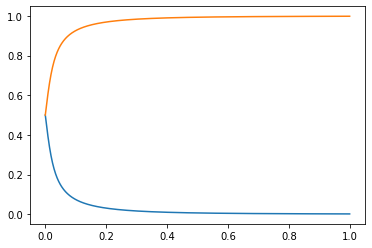

In [108]:
x0 = [0.1,0,0,0]
influxes_rev = np.linspace(0,1,800)

n = 100
t = np.linspace(0,100,n)

frac_y_rev = []
frac_z_rev = []

for flux in influxes_rev:
    k = [1,0.1,1,0.1,flux,0.1,1,0.01] #Same as above, but not Keq = 0.01 for the constrained system
    y = odeint(split,x0,t,args=(k,))
    j_y = [j(x,k)[0] for x in y]
    j_z = [j(x,k)[1] for x in y]
    frac_y_rev.append(j_y[-1]/(j_z[-1]+j_y[-1]))
    frac_z_rev.append(j_z[-1]/(j_z[-1]+j_y[-1]))

plt.plot(influxes_rev,frac_y_rev)
plt.plot(influxes_rev,frac_z_rev)

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


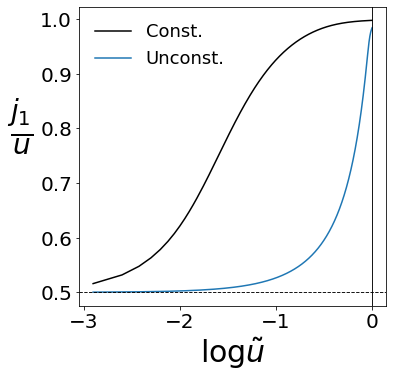

In [109]:
fig,ax = plt.subplots(figsize=(5.5,5.5))


ax.plot(np.log10(influxes_rev),frac_z_rev,linestyle='-',color='k',label='Const.')

ax.plot(np.log10(influxes),frac_z,linestyle='-',color='C00000',label='Unconst.')

ax.set_xlabel(r'$\log{\tilde{u}}} $',fontsize=30)
ax.set_ylabel(r'$\frac{j_1}{u}$',fontsize=40,rotation=0,labelpad=20)
ax.axhline(0.5,linestyle='--',color='k',linewidth=0.9)
ax.axvline(0,linestyle='-',color='k',linewidth=0.9)

ax.legend(frameon=False, fontsize=18,loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('split.pdf',bbox_inches='tight')
plt.savefig('split.png',bbox_inches='tight')

In [104]:
#Dynamic functions describing the split motif in the feedback configuration

def feedback_split(x,t,k):
    
    dpdt = k[0]-k[1]*x[0]/(k[2]+x[0])*k[3]/(k[3]+x[1])
    dydt = k[1]*x[0]/(k[2]+x[0])*k[3]/(k[3]+x[1])-(1-x[2]/x[1]/k[4])*(x[1]/0.1)/(1+x[1]/0.1+x[2]/1)
    dzdt = (1-x[2]/x[1]/k[4])*(x[1]/0.1)/(1+x[1]/0.1+x[2]/1) - k[5]*x[2]/(k[6]+x[2])
    dxdt = k[5]*x[0]/(k[6]+x[0]) - k[5]*x[3]/(k[6]+x[3])
    
    return [dpdt,dydt,dzdt,dxdt]

def j_feedback(x,k):
    j_z = k[5]*x[2]/(k[6]+x[2])
    j_x = k[5]*x[3]/(k[6]+x[3])
    
    return [j_z,j_x]

In [105]:
x0 = [0,0.1,0,0]
influxes = np.linspace(0,1,800)

n = 100
t = np.linspace(0,100,n)

frac_x_back = []
frac_z_back = []
frac_x_no = []
frac_z_no = []

for flux in influxes:
    k = [flux,1,0.1,0.1,0.01,1,0.1,0.1]
    y = odeint(feedback_split,x0,t,args=(k,))
    j_z = [j_feedback(x,k)[0] for x in y]
    j_x = [j_feedback(x,k)[1] for x in y]
    frac_x_back.append(j_x[-1]/(j_x[-1]+j_z[-1]))
    frac_z_back.append(j_z[-1]/(j_x[-1]+j_z[-1]))

    k = [flux,1,0.1,1000,0.01,1,0.1,0.1]
    y = odeint(feedback_split,x0,t,args=(k,))
    j_z = [j_feedback(x,k)[0] for x in y]
    j_x = [j_feedback(x,k)[1] for x in y]
    frac_x_no.append(j_x[-1]/(j_x[-1]+j_z[-1]))
    frac_z_no.append(j_z[-1]/(j_x[-1]+j_z[-1]))

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


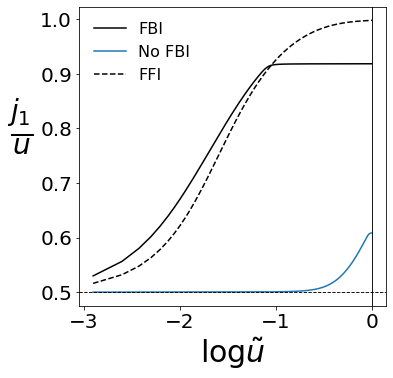

In [93]:
fig,ax = plt.subplots(figsize=(5.5,5.5))


ax.plot(np.log10(influxes),frac_x_back,linestyle='-',color='k',label='FBI')
ax.plot(np.log10(influxes),frac_x_no,linestyle='-',color='C00000',label='No FBI')
ax.plot(np.log10(influxes),frac_z_rev,linestyle='--',color='k',label='FFI')
#ax.plot(np.log10(influxes),frac_z,linestyle='--',color='C00000',label='Feedforward')

ax.set_xlabel(r'$\log{\tilde{u}}} $',fontsize=30)
ax.set_ylabel(r'$\frac{j_1}{u}$',fontsize=40,rotation=0,labelpad=20)
ax.axhline(0.5,linestyle='--',color='k',linewidth=0.9)
ax.axvline(0,linestyle='-',color='k',linewidth=0.9)

ax.legend(frameon=False, fontsize=16,loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('split_feedback.pdf',bbox_inches='tight')
plt.savefig('split_feedback.png',bbox_inches='tight')

In [83]:
#Dynamic equations describing the feedforward recombine motif

def recombine(x,t,k):
    
    dxdt = k[0] - (1-x[2]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[2]/1)
    dydt = k[2] - k[2]*x[1]/(k[3]+x[1])*k[1]/(x[0]+k[1])
    dpdt =(1-x[2]/x[0]/k[1])*(x[0]/0.1)/(1+x[0]/0.1+x[2]/1) - k[2]*x[2]/(k[3]+x[2]) + k[2]*x[1]/(k[3]+x[1])*k[1]/(x[0]+k[1])
    
    return [dxdt,dydt,dpdt]

def j_recombine(x,k):
    j_y = k[2]*x[1]/(k[3]+x[1])*k[1]/(x[0]+k[1])
    j_x = k[0]
    return [j_x, j_y]

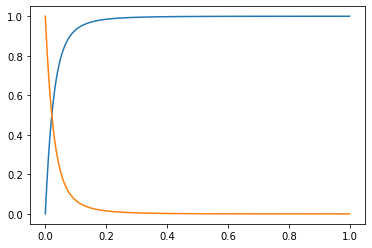

In [85]:
x0 = [0.1,0,0]
influxes = np.linspace(0,1,800)

n = 1000
t = np.linspace(0,1000,n)

z = []
frac_y_rev = []
frac_x_rev = []

for flux in influxes:
    k = [flux,0.01,1,0.1,1,0.1]
    y = odeint(recombine,x0,t,args=(k,))
    j_y = [j_recombine(x,k)[0] for x in y]
    j_x = [j_recombine(x,k)[1] for x in y]
    frac_y_rev.append(j_y[-1]/(j_x[-1]+j_y[-1]))
    frac_x_rev.append(j_x[-1]/(j_x[-1]+j_y[-1]))

plt.plot(influxes,frac_y_rev)
plt.plot(influxes,frac_x_rev)

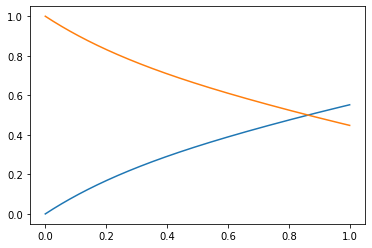

In [86]:
x0 = [0.1,0,0]
influxes = np.linspace(0,1,800)

n = 1000
t = np.linspace(0,1000,n)

z = []
frac_y = []
frac_x = []

for flux in influxes:
    k = [flux,1000,1,0.1,1,0.1]
    y = odeint(recombine,x0,t,args=(k,))
    j_y = [j_recombine(x,k)[0] for x in y]
    j_x = [j_recombine(x,k)[1] for x in y]
    frac_y.append(j_y[-1]/(j_x[-1]+j_y[-1]))
    frac_x.append(j_x[-1]/(j_x[-1]+j_y[-1]))

plt.plot(influxes,frac_y)
plt.plot(influxes,frac_x)

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


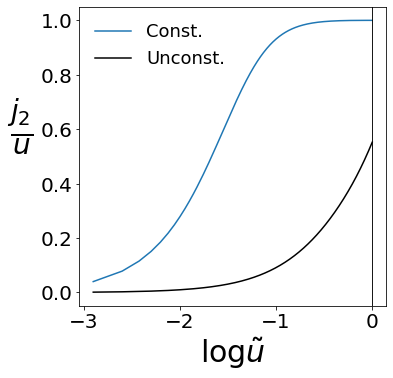

In [87]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

ax.plot(np.log10(influxes),frac_y_rev,linestyle='-',color='C00000',label='Const.')
ax.plot(np.log10(influxes),frac_y,linestyle='-',color='k',label='Unconst.')

ax.set_xlabel(r'$\log{\tilde{u}} $',fontsize=30)
ax.set_ylabel(r'$\frac{j_2}{u}$',fontsize=40,rotation=0,labelpad=20)
ax.axvline(0,linestyle='-',color='k',linewidth=0.9)

ax.legend(frameon=False, fontsize=18,loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('recombine.pdf',bbox_inches='tight')
#plt.savefig('recombine.png',bbox_inches='tight')

In [88]:
#Dynamic equations describing the recombine motif in the feedback configuration

def recombine_feedback(x,t,k):
    
    dxdt = k[2] - k[2]*x[0]/(k[3]+x[0])*k[4]/(k[4]+x[1])
    dydt = k[2]*x[2]/(k[3]+x[2]) - (1-x[2]/x[1]/k[1])*(x[1]/0.1)/(1+x[1]/0.1+x[2]/1)
    dpdt = k[0] - k[2]*x[2]/(k[3]+x[2]) + k[2]*x[0]/(k[3]+x[0])*k[4]/(k[4]+x[1])
    
    return [dxdt,dydt,dpdt]

def j_recombine_feedback(x,k):
    j_y = (1-x[2]/x[1]/k[1])*(x[1]/0.1)/(1+x[1]/0.1+x[2]/1)
    j_x = k[0]
    return [j_x, j_y]

In [89]:
x0 = [0,0.1,0]
influxes = np.linspace(0,1,800)

n = 1000
t = np.linspace(0,1000,n)

z = []
frac_y_back = []
frac_x_back = []

for flux in influxes:
    k = [flux,0.01,1,0.1,0.1,0.1]
    y = odeint(recombine_feedback,x0,t,args=(k,))
    j_y = [j_recombine_feedback(x,k)[0] for x in y]
    j_x = [j_recombine_feedback(x,k)[1] for x in y]
    frac_y_back.append(j_y[-1]/(j_x[-1]+j_y[-1]))
    frac_x_back.append(j_x[-1]/(j_x[-1]+j_y[-1]))

x0 = [0,0.1,0]
influxes = np.linspace(0,1,800)

n = 1000
t = np.linspace(0,1000,n)

z = []
frac_y_no = []
frac_x = []

for flux in influxes:
    k = [flux,1000,1,0.1,1000,1000]
    y = odeint(recombine_feedback,x0,t,args=(k,))
    j_y = [j_recombine_feedback(x,k)[0] for x in y]
    j_x = [j_recombine_feedback(x,k)[1] for x in y]
    frac_y_no.append(j_y[-1]/(j_x[-1]+j_y[-1]))
    frac_x.append(j_x[-1]/(j_x[-1]+j_y[-1]))

C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\euler\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


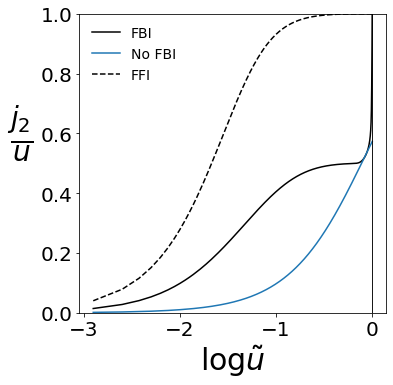

In [90]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

ax.plot(np.log10(influxes),frac_y_back,linestyle='-',color='k',label='FBI')
ax.plot(np.log10(influxes),frac_y_no,linestyle='-',color='C00000',label='No FBI')
ax.plot(np.log10(influxes),frac_y_rev,linestyle='--',color='k',label='FFI')

#ax.text(-0.3,0.5,r'$K_{eq} = 0.01$',fontsize=14)
#ax.text(0.3,0.5,r'$K_{eq} = 1000$',fontsize=14,color='C00000')
#ax.set_xlim(-1,1)
ax.set_xlabel(r'$\log{\tilde{u}}$',fontsize=30)
ax.set_ylabel(r'$\frac{j_2}{u}$',fontsize=40,rotation=0,labelpad=20)
ax.legend(frameon=False, fontsize=14,loc='upper left')
ax.axvline(0,linestyle='-',color='k',linewidth=0.9)

ax.set_ylim(0,1)

#ax.legend(frameon=False,fontsize=20,loc=(0.005,0.5))
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('recombine_feedback.pdf',bbox_inches='tight')
plt.savefig('recombine_feedback.pdf',bbox_inches='tight')

In [112]:
#Dynamic equations describing the linear motif in the feedback inhibition scenario

def linear_feedback(x,t,k):
    
    dsdt = k[0] - k[1]/(k[1]+x[1])*x[0]/(k[2]+x[0])*k[4]
    dxdt = k[1]/(k[1]+x[1])*x[0]/(k[2]+x[0])*k[4] - (1-(x[2]/x[1])/k[5])*(x[1]/k[2])/(1+x[1]/k[2]+x[2]/k[2])*k[3]
    dpdt = (1-(x[2]/x[1])/k[5])*(x[1]/k[2])/(1+x[1]/k[2]+x[2]/k[2])*k[3] - x[2]/(k[2]+x[2])*k[3]
    
    return [dsdt,dxdt,dpdt]

In [130]:
x0 = [0,0.1,0.1]
n = 10000
t = np.linspace(0,100,n)
flux = np.linspace(0,1,200)
ss = []
ss_noreg = []
ss_noconst = []

for u in flux:
    k = [u,1,0.1,1,1,0.01]
    y = odeint(linear_feedback,x0,t,args=(k,))
    ss.append(y[-1][0])
    
    k = [u,1000,0.1,1,1,0.01]
    y = odeint(linear_feedback,x0,t,args=(k,))
    ss_noreg.append(y[-1][0])
    
    k = [u,1,0.1,1,1,1000]
    y = odeint(linear_feedback,x0,t,args=(k,))
    ss_noconst.append(y[-1][0])

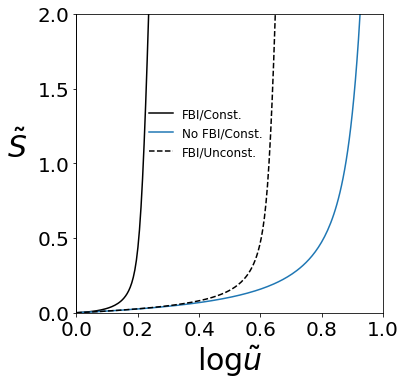

In [136]:
fig,ax = plt.subplots(figsize=(5.5,5.5))

ax.plot(flux,ss,linestyle='-',color='k',label='FBI/Const.')
ax.plot(flux,ss_noreg,linestyle='-',color='C00000',label='No FBI/Const.')
ax.plot(flux,ss_noconst,linestyle='--',color='k',label='FBI/Unconst.')

#ax.text(-0.3,0.5,r'$K_{eq} = 0.01$',fontsize=14)
#ax.text(0.3,0.5,r'$K_{eq} = 1000$',fontsize=14,color='C00000')
#ax.set_xlim(-1,1)
ax.set_xlabel(r'$\log{\tilde{u}}$',fontsize=30)
ax.set_ylabel(r'$\tilde{S}$',fontsize=30,rotation=0,labelpad=20)
ax.legend(frameon=False, fontsize=12,loc=(0.22,0.5))
ax.axvline(0,linestyle='-',color='k',linewidth=0.9)

ax.set_xlim(0,1)
ax.set_ylim(0,2)

#ax.legend(frameon=False,fontsize=20,loc=(0.005,0.5))
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('linear_feedback.pdf',bbox_inches='tight')
plt.savefig('linear_feedback.pdf',bbox_inches='tight')